In [1]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import random
from copy import deepcopy
import os
import pandas as pd
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


cpu


## Modèle Seq2Seq

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, fc_units, output_size, target_length, device):
        super(Seq2Seq, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.target_length = target_length
        self.device = device

        # Encoder
        self.encoder_gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Decoder
        self.decoder_gru = nn.GRU(input_size=output_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder_fc = nn.Linear(hidden_size, fc_units)
        self.decoder_out = nn.Linear(fc_units, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        # Encoder
        encoder_hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        _, encoder_hidden = self.encoder_gru(x, encoder_hidden)

        # Decoder
        decoder_input = x[:, -1, :].unsqueeze(1)  # Last element of input sequence
        decoder_hidden = encoder_hidden

        outputs = torch.zeros(batch_size, self.target_length, x.size(2), device=self.device)
        for ti in range(self.target_length):
            decoder_output, decoder_hidden = self.decoder_gru(decoder_input, decoder_hidden)
            decoder_output = F.relu(self.decoder_fc(decoder_output))
            decoder_output = self.decoder_out(decoder_output)
            outputs[:, ti:ti+1, :] = decoder_output
            decoder_input = decoder_output  # Use own predictions as inputs for next step

        return outputs

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)


## Loss

### Soft dtw

In [3]:
def pairwise_distances(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    return torch.clamp(dist, 0.0, float('inf'))


In [4]:
import numpy as np
from numba import jit

@jit(nopython = True)
def compute_softdtw(D, gamma):
  N = D.shape[0]
  M = D.shape[1]
  R = np.zeros((N + 2, M + 2)) + 1e8
  R[0, 0] = 0
  for j in range(1, M + 1):
    for i in range(1, N + 1):
      ### softmin
      r0 = -R[i - 1, j - 1] / gamma
      r1 = -R[i - 1, j] / gamma
      r2 = -R[i, j - 1] / gamma
      rmax = max(max(r0, r1), r2)
      rsum = np.exp(r0 - rmax) + np.exp(r1 - rmax) + np.exp(r2 - rmax)
      softmin = - gamma * (np.log(rsum) + rmax)
      R[i, j] = D[i - 1, j - 1] + softmin
  return R

@jit(nopython = True)
def compute_softdtw_backward(D_, R, gamma):
  N = D_.shape[0]
  M = D_.shape[1]
  D = np.zeros((N + 2, M + 2))
  E = np.zeros((N + 2, M + 2))
  D[1:N + 1, 1:M + 1] = D_
  E[-1, -1] = 1
  R[:, -1] = -1e8
  R[-1, :] = -1e8
  R[-1, -1] = R[-2, -2]
  for j in range(M, 0, -1):
    for i in range(N, 0, -1):
      a0 = (R[i + 1, j] - R[i, j] - D[i + 1, j]) / gamma
      b0 = (R[i, j + 1] - R[i, j] - D[i, j + 1]) / gamma
      c0 = (R[i + 1, j + 1] - R[i, j] - D[i + 1, j + 1]) / gamma
      a = np.exp(a0)
      b = np.exp(b0)
      c = np.exp(c0)
      E[i, j] = E[i + 1, j] * a + E[i, j + 1] * b + E[i + 1, j + 1] * c
  return E[1:N + 1, 1:M + 1]
 

In [5]:
import torch
from torch.autograd import Function


class SoftDTWBatch(Function):
    @staticmethod
    def forward(ctx, D, gamma = 1.0): # D.shape: [batch_size, N , N]
        dev = D.device
        batch_size,N,N = D.shape
        gamma = torch.FloatTensor([gamma]).to(dev)
        D_ = D.detach().cpu().numpy()
        g_ = gamma.item()

        total_loss = 0
        R = torch.zeros((batch_size, N+2 ,N+2)).to(dev)   
        for k in range(0, batch_size): # loop over all D in the batch    
            Rk = torch.FloatTensor(compute_softdtw(D_[k,:,:], g_)).to(dev)
            R[k:k+1,:,:] = Rk
            total_loss = total_loss + Rk[-2,-2]
        ctx.save_for_backward(D, R, gamma)
        return total_loss / batch_size
  
    @staticmethod
    def backward(ctx, grad_output):
        dev = grad_output.device
        D, R, gamma = ctx.saved_tensors
        batch_size,N,N = D.shape
        D_ = D.detach().cpu().numpy()
        R_ = R.detach().cpu().numpy()
        g_ = gamma.item()

        E = torch.zeros((batch_size, N ,N)).to(dev) 
        for k in range(batch_size):         
            Ek = torch.FloatTensor(compute_softdtw_backward(D_[k,:,:], R_[k,:,:], g_)).to(dev)
            E[k:k+1,:,:] = Ek

        return grad_output * E, None

### Path Soft DTW

In [6]:

@jit(nopython = True)
def my_max(x, gamma):
    # use the log-sum-exp trick
    max_x = np.max(x)
    exp_x = np.exp((x - max_x) / gamma)
    Z = np.sum(exp_x)
    return gamma * np.log(Z) + max_x, exp_x / Z

@jit(nopython = True)
def my_min(x,gamma) :
    min_x, argmax_x = my_max(-x, gamma)
    return - min_x, argmax_x

@jit(nopython = True)
def my_min_hessian_product(p, z, gamma):
    return - ( p * z - p * np.sum(p * z) ) /gamma

@jit(nopython = True)
def dtw_grad(theta, gamma):
    m = theta.shape[0]
    n = theta.shape[1]
    V = np.zeros((m + 1, n + 1))
    V[:, 0] = 1e10
    V[0, :] = 1e10
    V[0, 0] = 0

    Q = np.zeros((m + 2, n + 2, 3))

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            # theta is indexed starting from 0.
            v, Q[i, j] = my_min(np.array([V[i, j - 1],
                                                V[i - 1, j - 1],
                                                V[i - 1, j]]) , gamma)                        
            V[i, j] = theta[i - 1, j - 1] + v

    E = np.zeros((m + 2, n + 2))
    E[m + 1, :] = 0
    E[:, n + 1] = 0
    E[m + 1, n + 1] = 1
    Q[m + 1, n + 1] = 1

    for i in range(m,0,-1):
        for j in range(n,0,-1):
            E[i, j] = Q[i, j + 1, 0] * E[i, j + 1] + \
                      Q[i + 1, j + 1, 1] * E[i + 1, j + 1] + \
                      Q[i + 1, j, 2] * E[i + 1, j]
    
    return V[m, n], E[1:m + 1, 1:n + 1], Q, E


@jit(nopython = True)
def dtw_hessian_prod(theta, Z, Q, E, gamma):
    m = Z.shape[0]
    n = Z.shape[1]

    V_dot = np.zeros((m + 1, n + 1))
    V_dot[0, 0] = 0

    Q_dot = np.zeros((m + 2, n + 2, 3))
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            # theta is indexed starting from 0.
            V_dot[i, j] = Z[i - 1, j - 1] + \
                          Q[i, j, 0] * V_dot[i, j - 1] + \
                          Q[i, j, 1] * V_dot[i - 1, j - 1] + \
                          Q[i, j, 2] * V_dot[i - 1, j]

            v = np.array([V_dot[i, j - 1], V_dot[i - 1, j - 1], V_dot[i - 1, j]])
            Q_dot[i, j] = my_min_hessian_product(Q[i, j], v, gamma)
    E_dot = np.zeros((m + 2, n + 2))

    for j in range(n,0,-1):
        for i in range(m,0,-1):
            E_dot[i, j] = Q_dot[i, j + 1, 0] * E[i, j + 1] + \
                          Q[i, j + 1, 0] * E_dot[i, j + 1] + \
                          Q_dot[i + 1, j + 1, 1] * E[i + 1, j + 1] + \
                          Q[i + 1, j + 1, 1] * E_dot[i + 1, j + 1] + \
                          Q_dot[i + 1, j, 2] * E[i + 1, j] + \
                          Q[i + 1, j, 2] * E_dot[i + 1, j]

    return V_dot[m, n], E_dot[1:m + 1, 1:n + 1]


In [7]:
import torch
from torch.autograd import Function

class PathDTWBatch(Function):
    @staticmethod
    def forward(ctx, D, gamma): # D.shape: [batch_size, N , N]
        batch_size,N,N = D.shape
        device = D.device
        D_cpu = D.detach().cpu().numpy()
        gamma_gpu = torch.FloatTensor([gamma]).to(device)
        
        grad_gpu = torch.zeros((batch_size, N ,N)).to(device)
        Q_gpu = torch.zeros((batch_size, N+2 ,N+2,3)).to(device)
        E_gpu = torch.zeros((batch_size, N+2 ,N+2)).to(device)  
        
        for k in range(0,batch_size): # loop over all D in the batch    
            _, grad_cpu_k, Q_cpu_k, E_cpu_k = dtw_grad(D_cpu[k,:,:], gamma)     
            grad_gpu[k,:,:] = torch.FloatTensor(grad_cpu_k).to(device)
            Q_gpu[k,:,:,:] = torch.FloatTensor(Q_cpu_k).to(device)
            E_gpu[k,:,:] = torch.FloatTensor(E_cpu_k).to(device)
        ctx.save_for_backward(grad_gpu,D, Q_gpu ,E_gpu, gamma_gpu) 
        return torch.mean(grad_gpu, dim=0) 
    
    @staticmethod
    def backward(ctx, grad_output):
        device = grad_output.device
        grad_gpu, D_gpu, Q_gpu, E_gpu, gamma = ctx.saved_tensors
        D_cpu = D_gpu.detach().cpu().numpy()
        Q_cpu = Q_gpu.detach().cpu().numpy()
        E_cpu = E_gpu.detach().cpu().numpy()
        gamma = gamma.detach().cpu().numpy()[0]
        Z = grad_output.detach().cpu().numpy()
        
        batch_size,N,N = D_cpu.shape
        Hessian = torch.zeros((batch_size, N ,N)).to(device)
        for k in range(0,batch_size):
            _, hess_k = dtw_hessian_prod(D_cpu[k,:,:], Z, Q_cpu[k,:,:,:], E_cpu[k,:,:], gamma)
            Hessian[k:k+1,:,:] = torch.FloatTensor(hess_k).to(device)

        return  Hessian, None

### Loss DILATE

In [8]:
def dilate_loss(outputs, targets, alpha, gamma, device):
	# outputs, targets: shape (batch_size, N_output, 1)
	batch_size, N_output = outputs.shape[0:2]
	loss_shape = 0
	softdtw_batch = SoftDTWBatch.apply
	D = torch.zeros((batch_size, N_output,N_output )).to(device)
	for k in range(batch_size):
		Dk = pairwise_distances(targets[k,:,:].view(-1,1),outputs[k,:,:].view(-1,1))
		D[k:k+1,:,:] = Dk     
	loss_shape = softdtw_batch(D,gamma)
	
	path_dtw = PathDTWBatch.apply
	path = path_dtw(D,gamma)           
	Omega =  pairwise_distances(torch.range(1,N_output).view(N_output,1)).to(device)
	loss_temporal =  torch.sum( path*Omega ) / (N_output*N_output) 
	loss = alpha*loss_shape+ (1-alpha)*loss_temporal
	return loss, loss_shape, loss_temporal

## Entraînement et prédiction sur le dataset ECG5000

### Importation des données

In [9]:
### SEED POUR LA REPRODUCTIBILITE 

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# parameters
batch_size = 35
N = 500
N_input = 84
N_output = 56  
sigma = 0.01
gamma = 0.01

### IMPORTATION DU DATASET ECG

DATA_PATH = "../data/"

ecg_train = np.array(pd.read_table(DATA_PATH + "ECG5000/ECG5000_TRAIN.tsv"))[:, 1:, np.newaxis]
ecg_test = np.array(pd.read_table(DATA_PATH + "ECG5000/ECG5000_TEST.tsv"))[:, 1:, np.newaxis]


# Normalisation
ecg_train_flat = ecg_train.reshape(-1, ecg_train.shape[1])
ecg_test_flat = ecg_test.reshape(-1, ecg_test.shape[1])

scaler = StandardScaler()
ecg_train_flat = scaler.fit_transform(ecg_train_flat)
ecg_test_flat = scaler.transform(ecg_test_flat)

ecg_train = ecg_train_flat.reshape(ecg_train.shape[0], ecg_train.shape[1], 1)
ecg_test = ecg_test_flat.reshape(ecg_test.shape[0], ecg_test.shape[1], 1)


# On tronque pour s'assurer que la taille est un multiple de batch_size
num_train_batches = ecg_train.shape[0] // batch_size
ecg_train = ecg_train[:num_train_batches * batch_size]
num_test_batches = ecg_test.shape[0] // batch_size
ecg_test = ecg_test[:num_test_batches * batch_size]

print(ecg_train.shape, ecg_test.shape)


class ECG5000Dataset(Dataset):

    def __init__(self, data, output_length=56):
        self.data = torch.from_numpy(data).to(dtype=torch.float32)
        self.output_length = output_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index, :-self.output_length], self.data[index, -self.output_length:]
    
ecg_train_dataset = ECG5000Dataset(ecg_train)
ecg_test_dataset = ECG5000Dataset(ecg_test)
trainloader = DataLoader(ecg_train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(ecg_test_dataset, batch_size=batch_size, shuffle=False)


(490, 140, 1) (4480, 140, 1)


### Fonctions d'entraînement et d'évaluation des performances

In [10]:
def train_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=50, alpha=0.5):
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    ### learning rate adaptatif qui diminue au cours des epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs): 
        for i, data in enumerate(trainloader, 0):
            inputs, target = data
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            target = torch.tensor(target, dtype=torch.float32).to(device)

            # forward + backward + optimize
            outputs = net(inputs)
            loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)
            
            if (loss_type=='mse'):
                loss_mse = criterion(target,outputs)
                loss = loss_mse                   
 
            if (loss_type=='dilate'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)             
                  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

        ### on ajoute un pas au scheduler pour mettre le learning rate à jour
        scheduler.step()
        
        if (epoch % print_every == 0):
            print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
            m, d, t = eval_model(net,testloader, gamma,verbose=1)

  

def eval_model(net,loader, gamma,verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)
         
        # MSE    
        loss_mse = criterion(target,outputs)    

        # DTW and TDI
        loss_dtw, loss_tdi = 0,0
        for k in range(batch_size):         
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
            loss_dtw += sim
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean()) 
    return(np.array(losses_mse).mean(), np.array(losses_dtw).mean(), np.array(losses_tdi).mean())




### Entraînement des modèles

In [11]:
%%time
print('Entraînement du modèle Seq2Seq avec DILATE')
net_gru_dilate = Seq2Seq(input_size=1, hidden_size=128, num_layers=1, fc_units=16, output_size=1, target_length=N_output, device=device).to(device)
train_model(net_gru_dilate,loss_type='dilate',learning_rate=0.005, epochs=500, gamma=gamma, alpha=0.5, print_every=20)
final_mse, final_dtw, final_tdi = eval_model(net_gru_dilate, testloader, gamma)
print()

print('Entraînement du modèle Seq2Seq avec MSE')
net_gru_mse = Seq2Seq(input_size=1, hidden_size=128, num_layers=1, fc_units=16, output_size=1, target_length=N_output, device=device).to(device)
train_model(net_gru_mse,loss_type='mse',learning_rate=0.005, epochs=150, gamma=gamma, print_every=15)
final_mse_2, final_dtw_2, final_tdi_2 = eval_model(net_gru_mse, testloader, gamma)
print()

print('Entraînement du modèle Seq2Seq avec la soft DTW (dilate avec alpha = 1)')
net_gru_soft_dtw = Seq2Seq(input_size=1, hidden_size=128, num_layers=1, fc_units=16, output_size=1, target_length=N_output, device=device).to(device)
train_model(net_gru_soft_dtw,loss_type='dilate',learning_rate=0.005, epochs=500, gamma=gamma, alpha =1, print_every=20)
final_mse_3, final_dtw_3, final_tdi_3 = eval_model(net_gru_soft_dtw, testloader, gamma)

Entraînement du modèle Seq2Seq avec DILATE
epoch  0  loss  21.76432991027832  loss shape  38.49160385131836  loss temporal  5.037054538726807
 Eval mse=  0.9723811177536845  dtw=  6.372413344833282  tdi=  6.503027984352222
epoch  20  loss  19.77092170715332  loss shape  35.17805862426758  loss temporal  4.363784313201904
 Eval mse=  1.1464757337234914  dtw=  3.518160048847432  tdi=  4.026211521159803
epoch  40  loss  5.80705451965332  loss shape  9.056907653808594  loss temporal  2.5572011470794678
 Eval mse=  1.0566001986153424  dtw=  3.146897479228345  tdi=  2.6700598891900507
epoch  60  loss  12.705951690673828  loss shape  20.502893447875977  loss temporal  4.9090094566345215
 Eval mse=  1.5988084403797984  dtw=  3.5917892063607084  tdi=  3.7494389748086734
epoch  80  loss  2.75370454788208  loss shape  4.563213348388672  loss temporal  0.9441955089569092
 Eval mse=  0.7590750907547772  dtw=  2.224940302787777  tdi=  0.9713265733190597
epoch  100  loss  2.35041880607605  loss shape

### Visualisation des résultats

Evaluation des modèles : 


,Loss,MSE,DTW,TDI
0,DILATE,0.490930,1.800311,0.508728
1,MSE,0.394891,2.048353,0.537472
2,SOFT DTW,1.105341,3.017659,4.318873


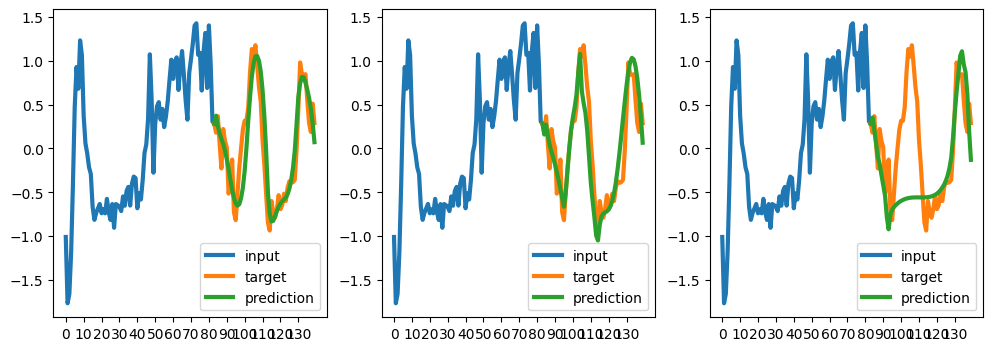

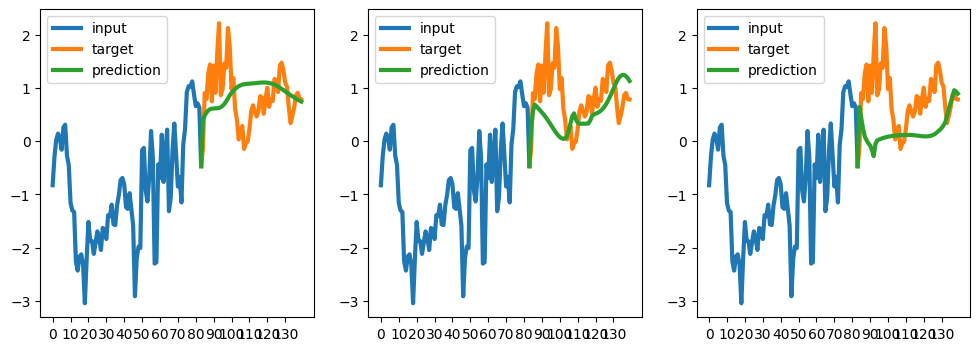

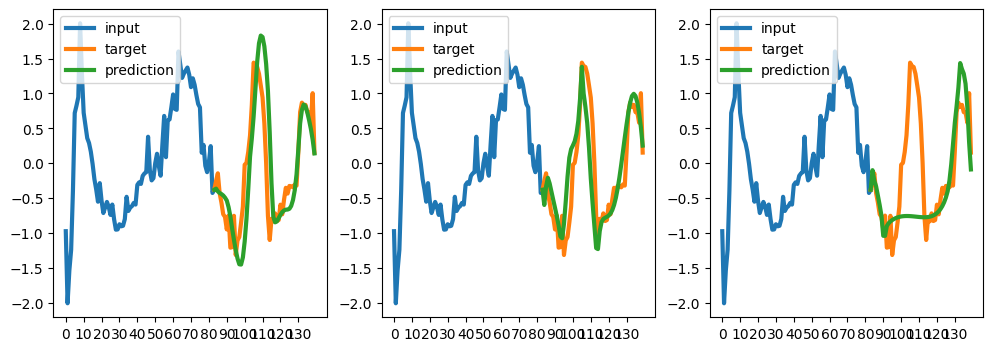

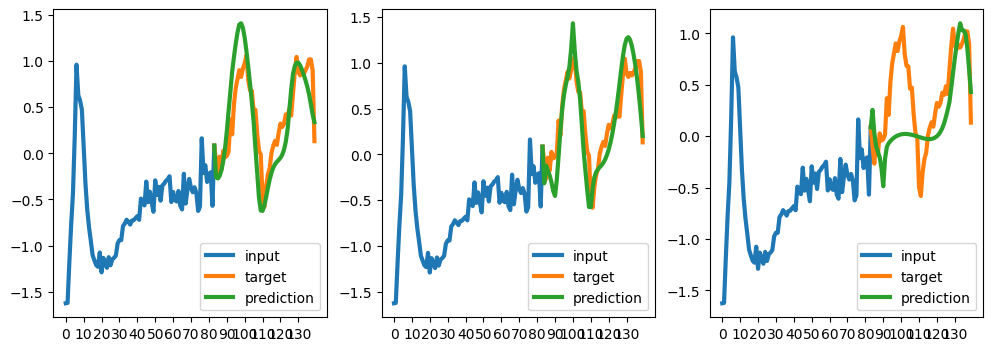

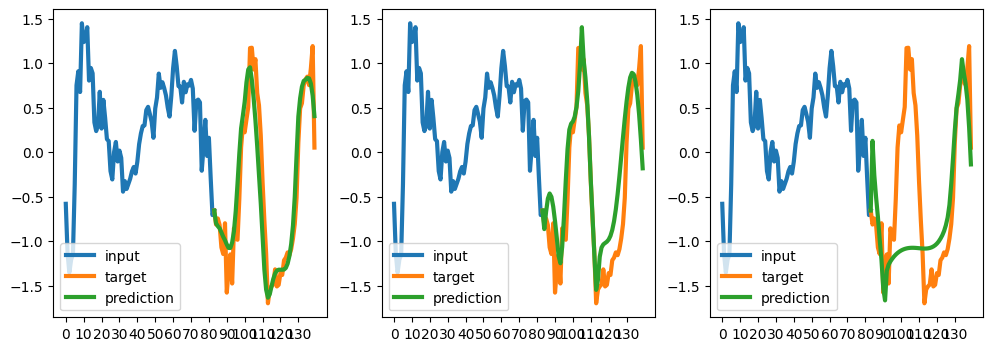

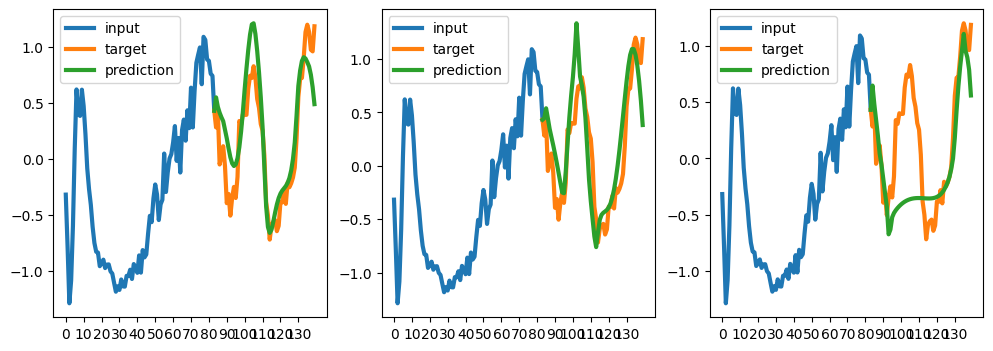

In [12]:
### TABLEAU RECAPITULATIF DES METRICS

metrics_df = pd.DataFrame({
    'Loss' : ['DILATE', 'MSE', 'SOFT DTW'],
    'MSE': [final_mse, final_mse_2, final_mse_3],
    'DTW': [final_dtw, final_dtw_2, final_dtw_3],
    'TDI': [final_tdi, final_tdi_2, final_tdi_3]
})

print("Evaluation des modèles : ")
display(metrics_df)

### PREDICTION DE QUELQUES ECG

gen_test = iter(testloader)
test_inputs, test_targets = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)
criterion = torch.nn.MSELoss()

nets = [net_gru_mse,net_gru_dilate,net_gru_soft_dtw]

for ind in [6,8,12,13,14,15]: ### Quelques exemples parlants
    plt.figure(figsize=(12, 4))
    plt.rcParams['figure.figsize'] = (17.0,5.0)  
    k = 1
    for net in nets:
        pred = net(test_inputs).to(device)

        input = test_inputs.detach().cpu().numpy()[ind,:,:]
        target = test_targets.detach().cpu().numpy()[ind,:,:]
        preds = pred.detach().cpu().numpy()[ind,:,:]

        plt.subplot(1,3,k)
        plt.plot(range(0, len(input)), input.flatten(), label='input', linewidth=3)
        plt.plot(range(len(input)-1,len(input)+len(preds)), np.concatenate([ input[len(input)-1:len(input)].flatten(), target.flatten() ]) ,label='target',linewidth=3)   
        plt.plot(range(len(input)-1,len(input)+len(preds)),  np.concatenate([ input[len(input)-1:len(input)].flatten(), preds.flatten() ])  ,label='prediction',linewidth=3)       
        plt.xticks(range(0,140,10))
        plt.legend()
        k = k+1

    plt.show()